<a href="https://colab.research.google.com/github/BhagwatPriyanka/CE888-Assignment2/blob/main/Bias_Detection_and_Mitigation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install 'aif360[all]'

     |████████████████████████████████| 184kB 6.0MB/s 
     |████████████████████████████████| 2.6MB 7.7MB/s 
     |████████████████████████████████| 21.2MB 5.7MB/s 
     |████████████████████████████████| 9.2MB 38.4MB/s 
     |████████████████████████████████| 972kB 47.1MB/s 
     |████████████████████████████████| 276kB 29.1MB/s 
     |████████████████████████████████| 358kB 38.9MB/s 
     |████████████████████████████████| 21.6MB 1.3MB/s 
     |████████████████████████████████| 235kB 35.9MB/s 
     |████████████████████████████████| 3.4MB 39.8MB/s 
     |████████████████████████████████| 747kB 32.0MB/s 
     |████████████████████████████████| 25.3MB 1.7MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394769 sha256=25301da2b9200519e148db99d2cff7a5cf5f191ae9ebb15e65139c50efdd9c8d
  Stored in directory: /root/.cache/pip/wheels/66/82/7b/ac2a79b8caf97e15ed415162a7f272cbba1e2e2c851fa76ae3
  Created wheel for lime: filename=lime-0.2.0.

In [2]:
import sys
sys.path.append("../")

%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from tqdm import tqdm
from warnings import warn

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Libraries to study
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

# ML libraries
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MaxAbsScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interactive, FloatSlider

In [3]:

# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [4]:
#Importing dataset saved in github
!git clone https://github.com/BhagwatPriyanka/CE888-Assignment2.git

Cloning into 'CE888-Assignment2'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 44 (delta 33), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [5]:
#ESSEX
#using dataset already imported

essex18_3 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-03-essex-stop-and-search.csv')
essex18_3["Month"] = "March"
essex18_4 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-04-essex-stop-and-search.csv')
essex18_4["Month"] = "April"
essex18_5 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-05-essex-stop-and-search.csv')
essex18_5["Month"] = "May"
essex18_6 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-06-essex-stop-and-search.csv')
essex18_6["Month"] = "June"
essex18_7 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-07-essex-stop-and-search.csv')
essex18_7["Month"] = "July"
essex18_8 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-08-essex-stop-and-search.csv')
essex18_8["Month"] = "August"
essex18_9 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-09-essex-stop-and-search.csv')
essex18_9["Month"] = "September"
essex18_10 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-10-essex-stop-and-search.csv')
essex18_10["Month"] = "October"
essex18_11 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-11-essex-stop-and-search.csv')
essex18_11["Month"] = "November"
essex18_12 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2018-12-essex-stop-and-search.csv')
essex18_12["Month"] = "December"
essex19_1 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-01-essex-stop-and-search.csv')
essex19_1["Month"] = "January"
essex19_2 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-02-essex-stop-and-search.csv')
essex19_2["Month"] = "February"
essex19_3 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-03-essex-stop-and-search.csv')
essex19_3["Month"] = "March"
essex19_4 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-04-essex-stop-and-search.csv')
essex19_4["Month"] = "April"
essex19_5 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-05-essex-stop-and-search.csv')
essex19_5["Month"] = "May"
essex19_6 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-06-essex-stop-and-search.csv')
essex19_6["Month"] = "June"
essex19_7 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-07-essex-stop-and-search.csv')
essex19_7["Month"] = "July"
essex19_8 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-08-essex-stop-and-search.csv')
essex19_8["Month"] = "August"
essex19_9 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-09-essex-stop-and-search.csv')
essex19_9["Month"] = "September"
essex19_10 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-10-essex-stop-and-search.csv')
essex19_10["Month"] = "October"
essex19_11 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-11-essex-stop-and-search.csv')
essex19_11["Month"] = "November"
essex19_12 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2019-12-essex-stop-and-search.csv')
essex19_12["Month"] = "December"
essex20_1 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-01-essex-stop-and-search.csv')
essex20_1["Month"] = "January"
essex20_2 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-02-essex-stop-and-search.csv')
essex20_2["Month"] = "February"
essex20_3 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-03-essex-stop-and-search.csv')
essex20_3["Month"] = "March"
essex20_4 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-04-essex-stop-and-search.csv')
essex20_4["Month"] = "April"
essex20_5 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-05-essex-stop-and-search.csv')
essex20_5["Month"] = "May"
essex20_6 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-06-essex-stop-and-search.csv')
essex20_6["Month"] = "June"
essex20_7 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-07-essex-stop-and-search.csv')
essex20_7["Month"] = "July"
essex20_8 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-08-essex-stop-and-search.csv')
essex20_8["Month"] = "August"
essex20_9 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-09-essex-stop-and-search.csv')
essex20_9["Month"] = "September"
essex20_10 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-10-essex-stop-and-search.csv')
essex20_10["Month"] = "October"
essex20_11 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-11-essex-stop-and-search.csv')
essex20_11["Month"] = "November"
essex20_12 = pd.read_csv('/content/CE888-Assignment2/Essex Dataset/2020-12-essex-stop-and-search.csv')
essex20_12["Month"] = "December"
essex18 = pd.concat([essex18_3,essex18_4,essex18_5,essex18_6,essex18_7,essex18_8,essex18_9,essex18_10,essex18_11,essex18_12])
essex18["Year"] = 2018
essex19 = pd.concat([essex19_1,essex19_2,essex19_3,essex19_4,essex19_5,essex19_6,essex19_7,essex19_8,essex19_9,essex19_10,essex19_11,essex19_12])
essex19["Year"] = 2019
essex20 = pd.concat([essex20_1,essex20_2,essex20_3,essex20_4,essex20_5,essex20_6,essex20_7,essex20_8,essex20_9,essex20_10,essex20_11,essex20_12])
essex20["Year"] = 2020
essex = pd.concat([essex18,essex19,essex20])
essex["City"] = "Essex"
essex= pd.DataFrame(essex)
essex.head()

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,Month,Year,City
0,Person search,2018-03-01T14:01:00+00:00,True,NaN,51.596673,0.687869,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,1.0,False,March,2018,Essex
1,Person and Vehicle search,2018-03-01T14:01:00+00:00,True,NaN,51.596673,0.687869,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,1.0,False,March,2018,Essex
2,Person search,2018-03-01T17:01:00+00:00,False,NaN,51.764363,0.088416,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Offender given drugs possession warning,1.0,False,March,2018,Essex
3,Person and Vehicle search,2018-03-01T18:01:00+00:00,False,NaN,51.819522,1.024970,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,0.0,False,March,2018,Essex
4,Person and Vehicle search,2018-03-01T18:01:00+00:00,False,NaN,51.819522,1.024970,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,0.0,False,March,2018,Essex


**Data Cleaning and Data Wrangling**

In [6]:
essex.columns = essex.columns.str.lower().str.replace(' ', '_')
essex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44639 entries, 0 to 1003
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   type                                      44639 non-null  object 
 1   date                                      44639 non-null  object 
 2   part_of_a_policing_operation              44639 non-null  bool   
 3   policing_operation                        0 non-null      float64
 4   latitude                                  43696 non-null  float64
 5   longitude                                 43696 non-null  float64
 6   gender                                    42145 non-null  object 
 7   age_range                                 40792 non-null  object 
 8   self-defined_ethnicity                    42170 non-null  object 
 9   officer-defined_ethnicity                 41796 non-null  object 
 10  legislation                        

In [7]:
essex.shape

(44639, 18)

In [8]:
#Getting subset
sort = essex[['type','date','gender','age_range','officer-defined_ethnicity','object_of_search','outcome']]
data = sort.dropna()
data = data.reset_index(drop=True)
data.describe()

,type,date,gender,age_range,officer-defined_ethnicity,object_of_search,outcome
count,36390,36390,36390,36390,36390,36390,36390
unique,2,11281,2,5,4,8,15
top,Person search,2019-09-17T08:01:00+00:00,Male,18-24,White,Controlled drugs,A no further action disposal
freq,26692,65,32198,13670,29677,24730,26447


In [9]:
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date

In [10]:
data.rename({'officer-defined_ethnicity':'ethnicity'}, axis=1, inplace=True)
data.head()

,type,date,gender,age_range,ethnicity,object_of_search,outcome
0,Person search,2018-03-01,Male,18-24,White,Controlled drugs,Offender given drugs possession warning
1,Person and Vehicle search,2018-03-01,Male,18-24,White,Controlled drugs,Offender given drugs possession warning
2,Person search,2018-03-01,Male,25-34,White,Controlled drugs,Offender given drugs possession warning
3,Person and Vehicle search,2018-03-01,Male,18-24,White,Controlled drugs,Nothing found - no further action
4,Person and Vehicle search,2018-03-01,Male,18-24,White,Controlled drugs,Nothing found - no further action


**Data Analysis**

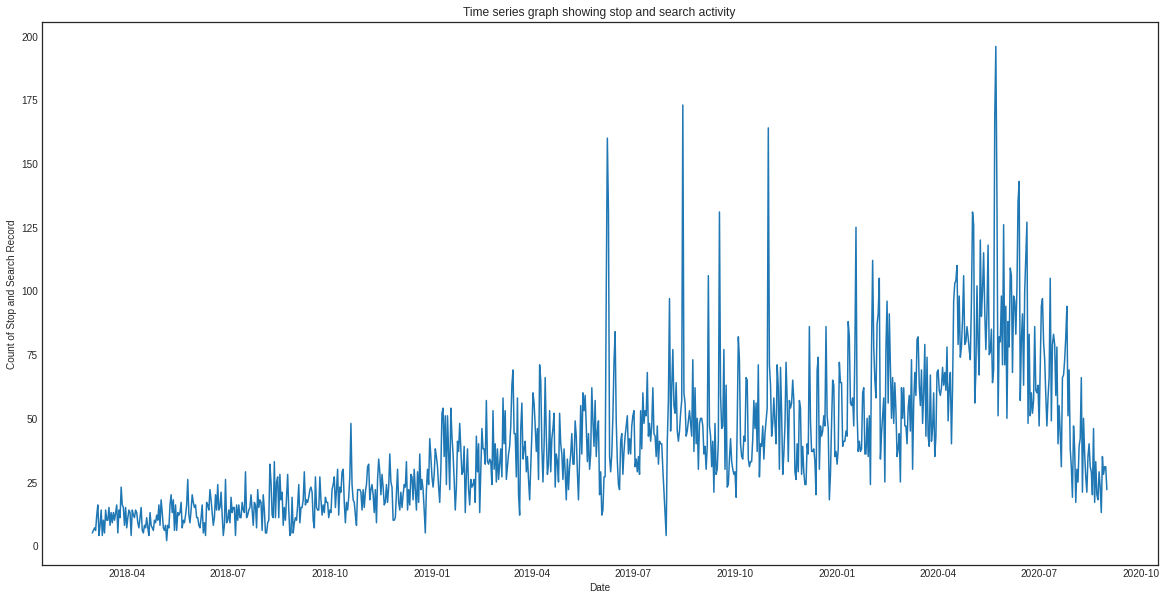

In [11]:
count_by_date = data.groupby('date').size()

plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Count of Stop and Search Record')
plt.title('Time series graph showing stop and search activity')
plt.plot(count_by_date);

In [12]:
data['ethnicity'].value_counts()

White    29677
Black     3747
Asian     1600
Other     1366
Name: ethnicity, dtype: int64

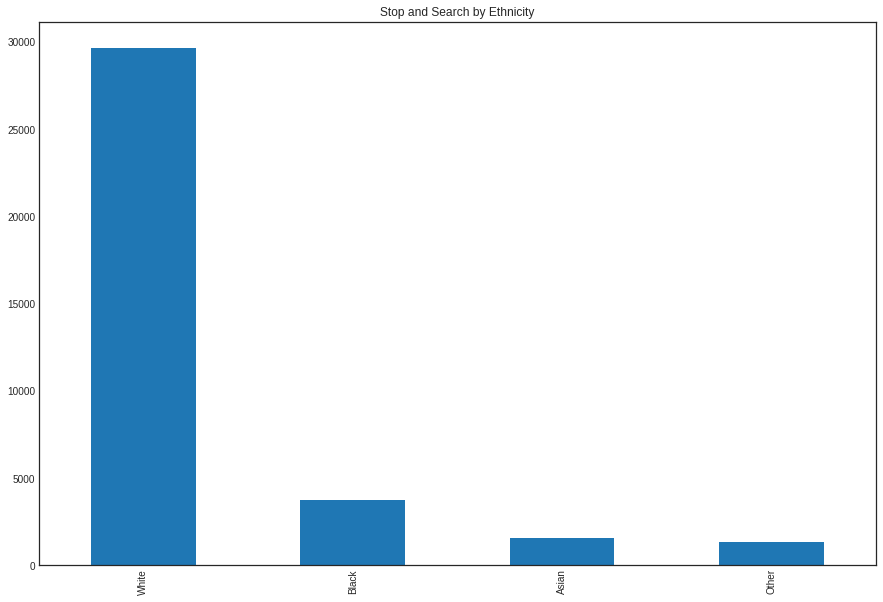

In [13]:
data['ethnicity'].value_counts().plot.bar(title='Stop and Search by Ethnicity',figsize=(15,10));

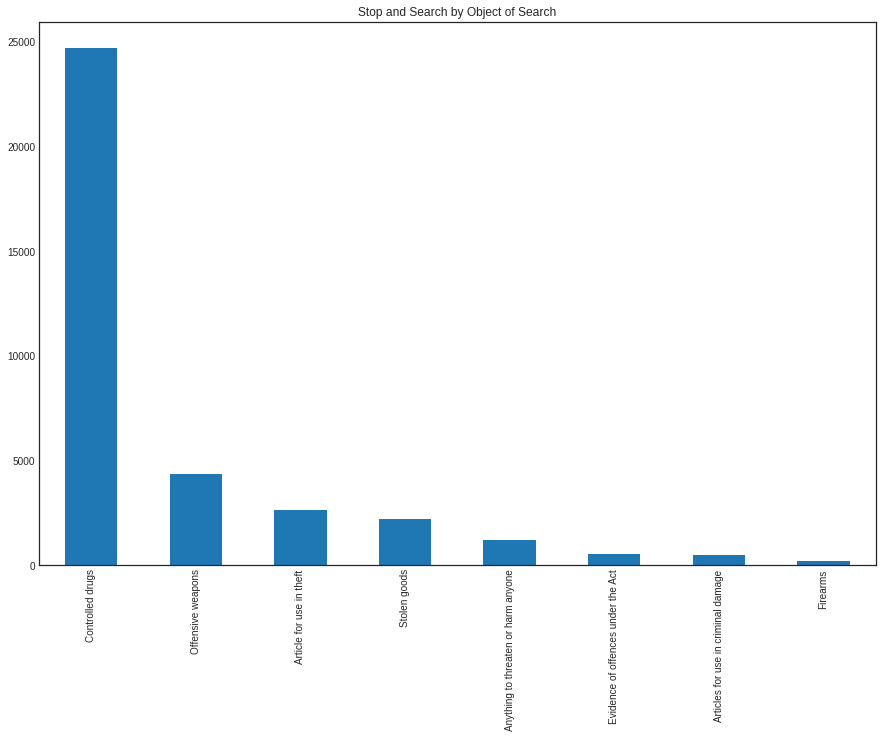

In [14]:
data['object_of_search'].value_counts().plot.bar(title='Stop and Search by Object of Search',figsize=(15,10));

So the most likely scenario is for a white person to be stopped on suspicion of possessing controlled drugs.


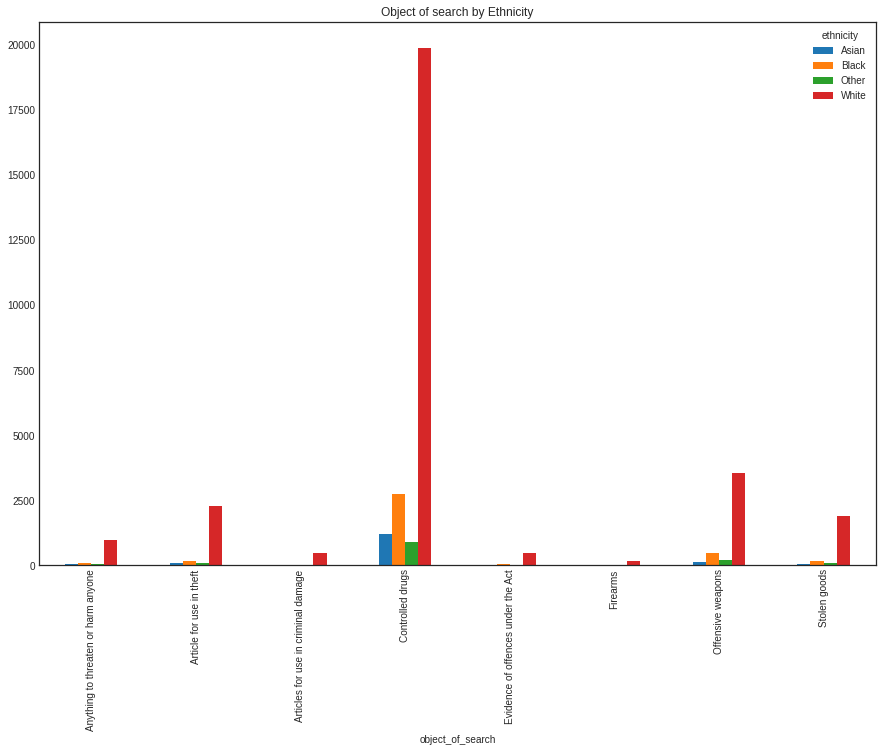

In [15]:
data.groupby('ethnicity')['object_of_search'].value_counts().unstack(0).plot.bar(title='Object of search by Ethnicity', figsize=(15,10));

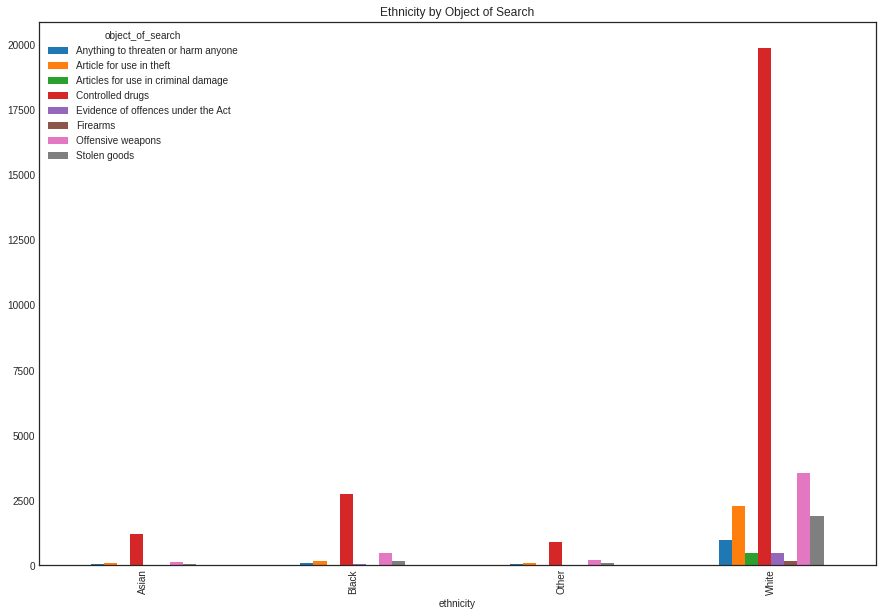

In [16]:
data.groupby('object_of_search')['ethnicity'].value_counts().unstack(0).plot.bar(title='Ethnicity by Object of Search', figsize=(15,10));

This demonstrates that Controlled Drugs are the most common reason for arrest for people of all ethnicities. Offensive Weapons came in second place. In addition, we can see that White people are in the lead for the two major crimes.

Let's remove all but the top two and analyse them.

In [17]:
counts = data['object_of_search'].value_counts()
counts
counts[counts > 4000]

Controlled drugs     24730
Offensive weapons     4348
Name: object_of_search, dtype: int64

In [18]:
drugs = data.object_of_search == 'Controlled drugs'
weapons = data.object_of_search == 'Offensive weapons'

drugs_p_weapons = data.object_of_search[weapons].count() + data.object_of_search[weapons].count()

In [19]:
drugs_prc = data.object_of_search[drugs].count() / drugs_p_weapons
weapons_prc = data.object_of_search[weapons].count() / drugs_p_weapons

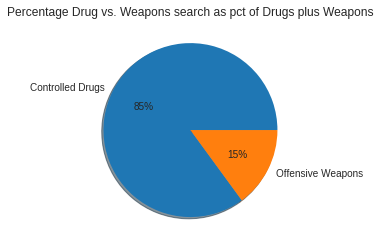

In [20]:
# pie chart
labels = 'Controlled Drugs', 'Offensive Weapons'
fracs = [drugs_prc, weapons_prc]
explode = (0,0)
plt.axis("equal")
plt.title('Percentage Drug vs. Weapons search as pct of Drugs plus Weapons')
plt.pie(fracs, explode=explode, labels=labels, autopct='%.0f%%', shadow=True);

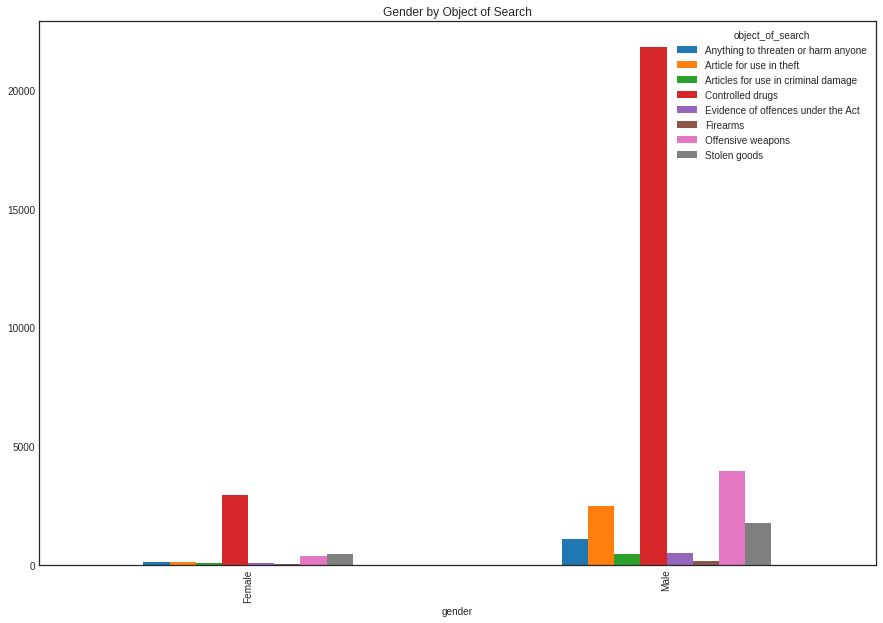

In [21]:
data.groupby('object_of_search')['gender'].value_counts().unstack(0).plot.bar(title='Gender by Object of Search', figsize=(15,10));

Despite the fact that males make up the vast majority of the population, the pattern of controlled drug searches persists. Let's make a pie chart to show how large the male population is.

In [22]:
gender_male = data.gender == 'Male'
gender_female = data.gender == 'Female'

gender_male_prc = data.gender[gender_male].count() / len(data)
gender_female_prc = data.gender[gender_female].count() / len(data)

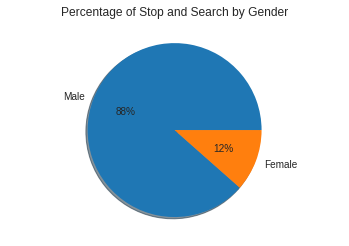

In [23]:
#pie chart
labels = 'Male', 'Female'
fracs = [gender_male_prc, gender_female_prc]
explode = (0.0,0)
plt.axis("equal")
plt.title('Percentage of Stop and Search by Gender')
plt.pie(fracs, explode=explode, labels=labels, autopct='%.0f%%', shadow=True);

In [24]:
age_u10 = data.age_range == 'under 10'
age_10 = data.age_range == '10-17'
age_18 = data.age_range == '18-24'
age_25 = data.age_range == '25-34'
age_34 = data.age_range == 'over 34'

In [25]:
age_u10_prc = data.age_range[age_u10].count() / len(data)
age_10_prc = data.age_range[age_10].count() / len(data)
age_18_prc = data.age_range[age_18].count() / len(data)
age_25_prc = data.age_range[age_25].count() / len(data)
age_34_prc = data.age_range[age_34].count() / len(data)

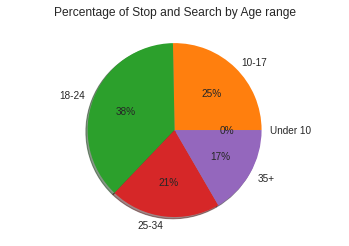

In [26]:
#pie chart
labels = 'Under 10', '10-17', '18-24', '25-34', '35+'
fracs = [age_u10_prc, age_10_prc, age_18_prc, age_25_prc, age_34_prc]
explode = (0,0,0,0,0)
plt.axis("equal")
plt.title('Percentage of Stop and Search by Age range')
plt.pie(fracs, explode=explode, labels=labels, autopct='%.0f%%', shadow=True);

This is more intriguing: 25% of the data is from the ages of 10 to 17. This is a very young person! The ages of 10 to 17 and 18 to 24 account for 63% of the total! This reveals who the police believe is committing the crimes rather than who is actually committing them, but it is a fascinating perspective.



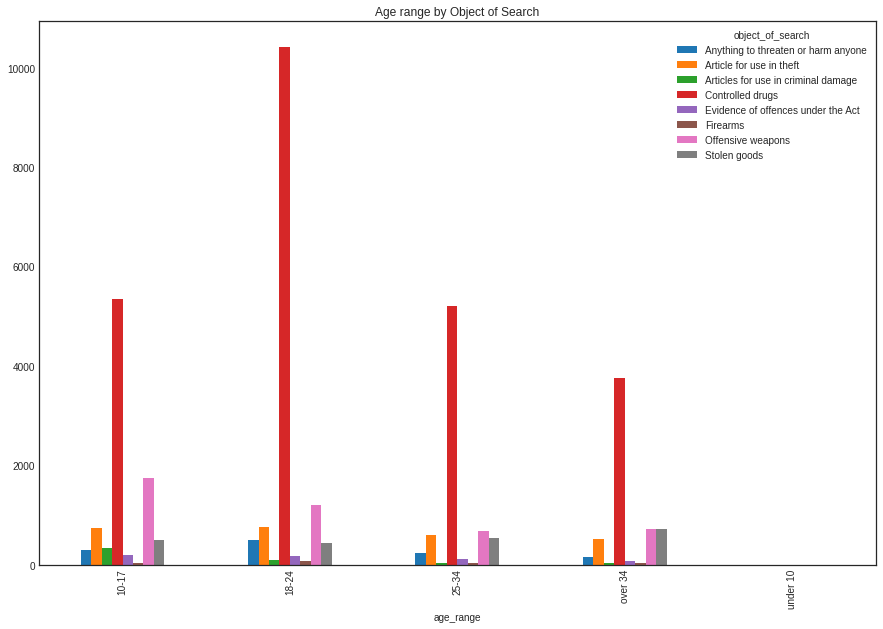

In [27]:
data.groupby('object_of_search')['age_range'].value_counts().unstack(0).plot.bar(title='Age range by Object of Search', figsize=(15,10));

We can see that 10-17 year olds are ahead when it comes to possessing offensive weapons. We can also see how common it is for 18-24 year olds to be stopped for drug-related offences.

Finally, let's take a look at some time series graphs and see if any patterns have changed over time.

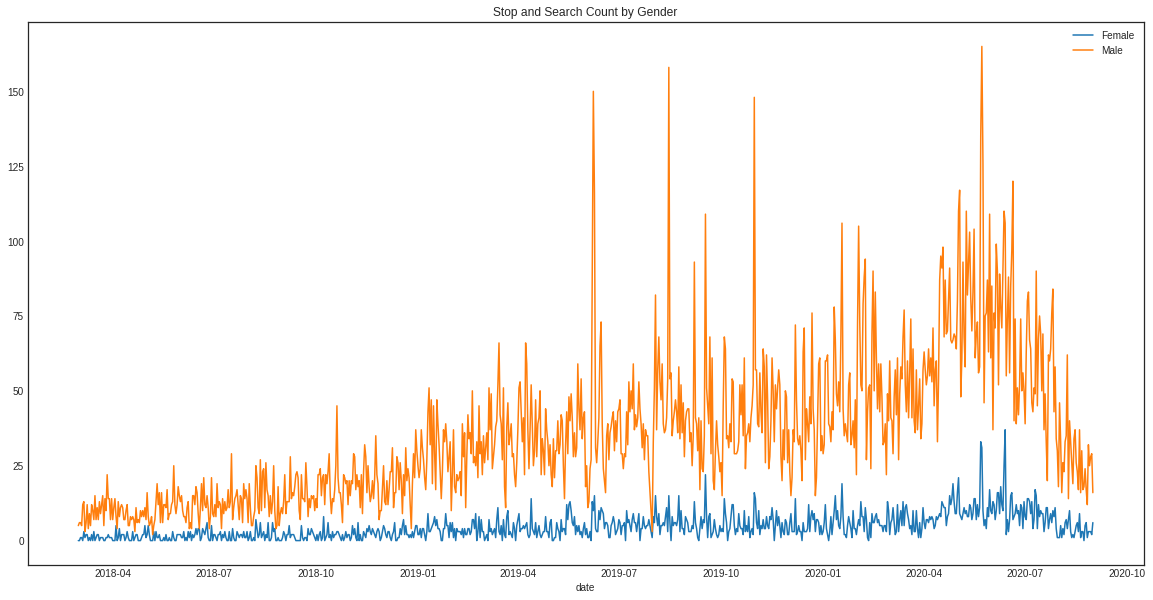

In [28]:
gender_count = data.groupby('date')
gender_count = gender_count.gender.apply(pd.value_counts).unstack(-1).fillna(0)


gender_count.plot(kind='line',figsize=(20,10), title='Stop and Search Count by Gender');

The slight downward trend in both males and females appears to be stable. There appear to be some seasonal changes in the data, especially beginning in August 2020.


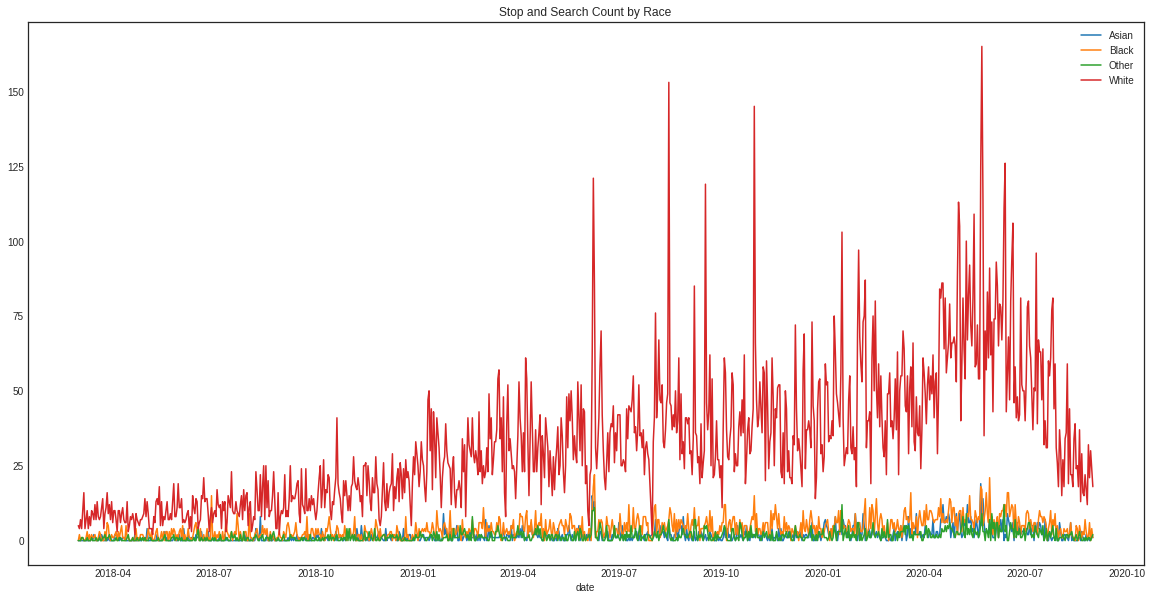

In [29]:
race_count = data.groupby('date')
race_count = race_count.ethnicity.apply(pd.value_counts).unstack(-1).fillna(0)

race_count.plot(kind='line',figsize=(20,10), title='Stop and Search Count by Race');

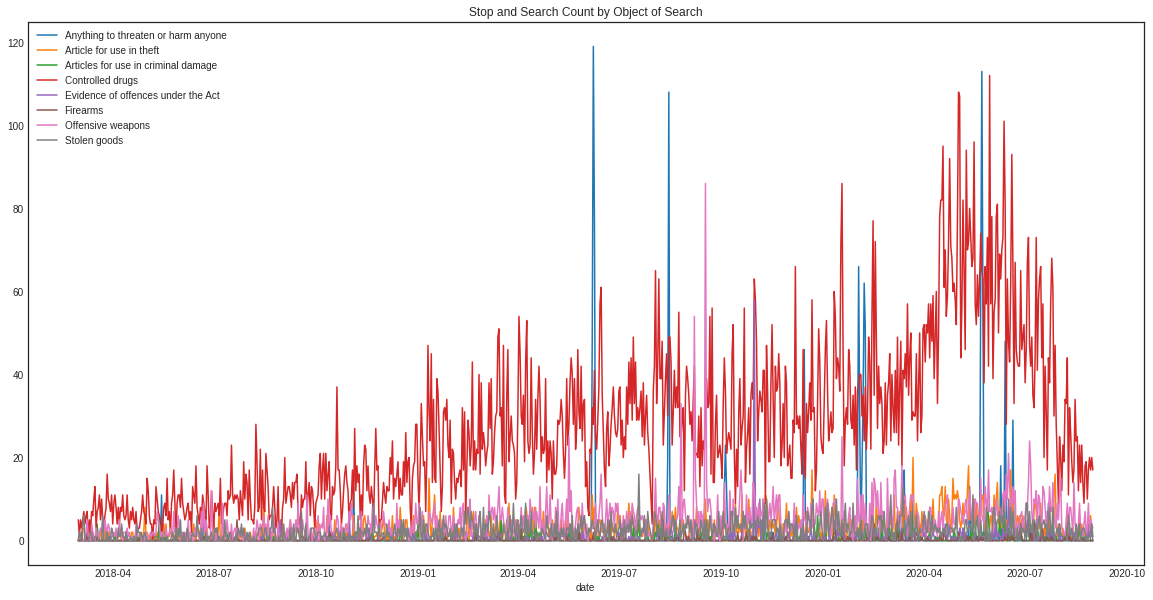

In [30]:
object_count = data.groupby('date')
object_count = object_count.object_of_search.apply(pd.value_counts).unstack(-1).fillna(0)

object_count.plot(kind='line',figsize=(20,10), title='Stop and Search Count by Object of Search');

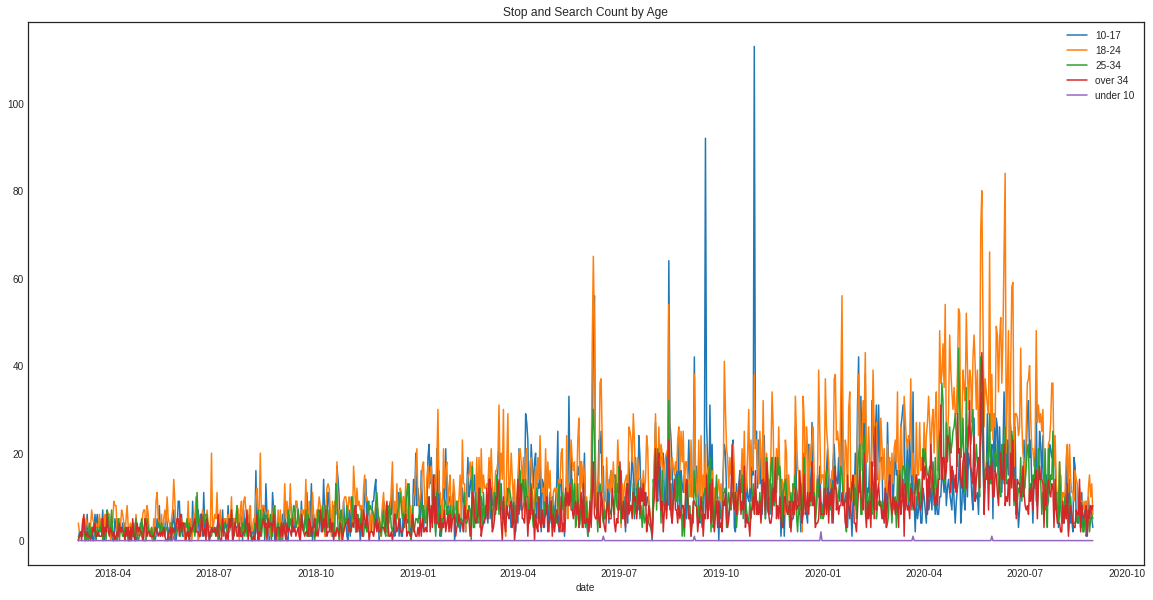

In [31]:
age_count = data.groupby('date')
age_count = age_count.age_range.apply(pd.value_counts).unstack(-1).fillna(0)
age_count.plot(kind='line', figsize=(20,10), title='Stop and Search Count by Age');

We can see that the two major reasons for stopping anyone are suspicion of possessing a controlled substance, such as drugs, or offensive weapons. These patterns remain true regardless of race, age, or gender.



In [32]:
data['outcome'].value_counts()

A no further action disposal                    26447
Arrest                                           3894
Khat or Cannabis warning                         3239
Community resolution                             1778
Caution (simple or conditional)                   404
Nothing found - no further action                 220
Summons / charged by post                         215
Penalty Notice for Disorder                        80
Suspect arrested                                   50
Offender given drugs possession warning            23
Local resolution                                   13
Article found - Detailed outcome unavailable       11
Offender cautioned                                  7
Suspect summonsed to court                          5
Offender given penalty notice                       4
Name: outcome, dtype: int64

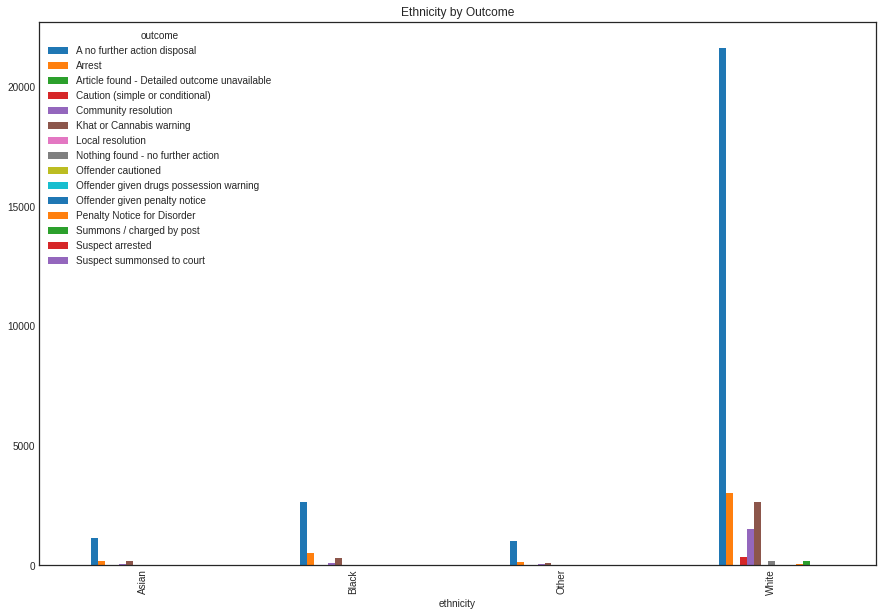

In [33]:
data.groupby('outcome')['ethnicity'].value_counts().unstack(0).plot.bar(title='Ethnicity by Outcome', figsize=(15,10));

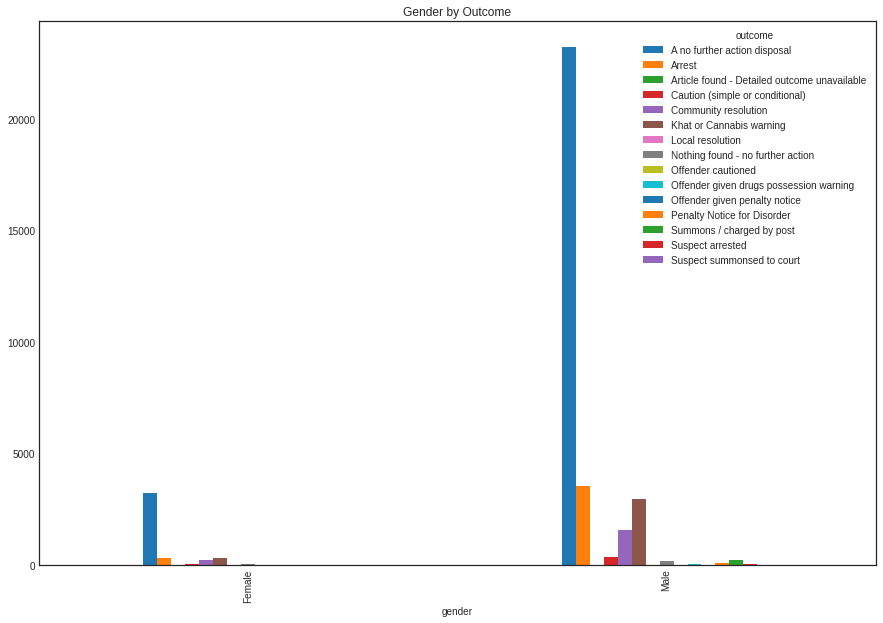

In [34]:
data.groupby('outcome')['gender'].value_counts().unstack(0).plot.bar(title='Gender by Outcome', figsize=(15,10));

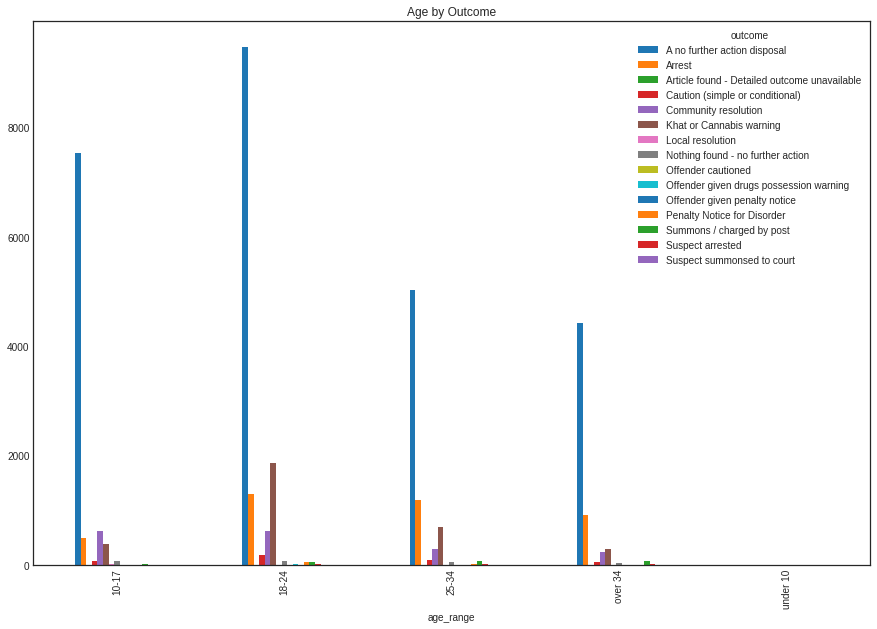

In [35]:
data.groupby('outcome')['age_range'].value_counts().unstack(0).plot.bar(title='Age by Outcome', figsize=(15,10));

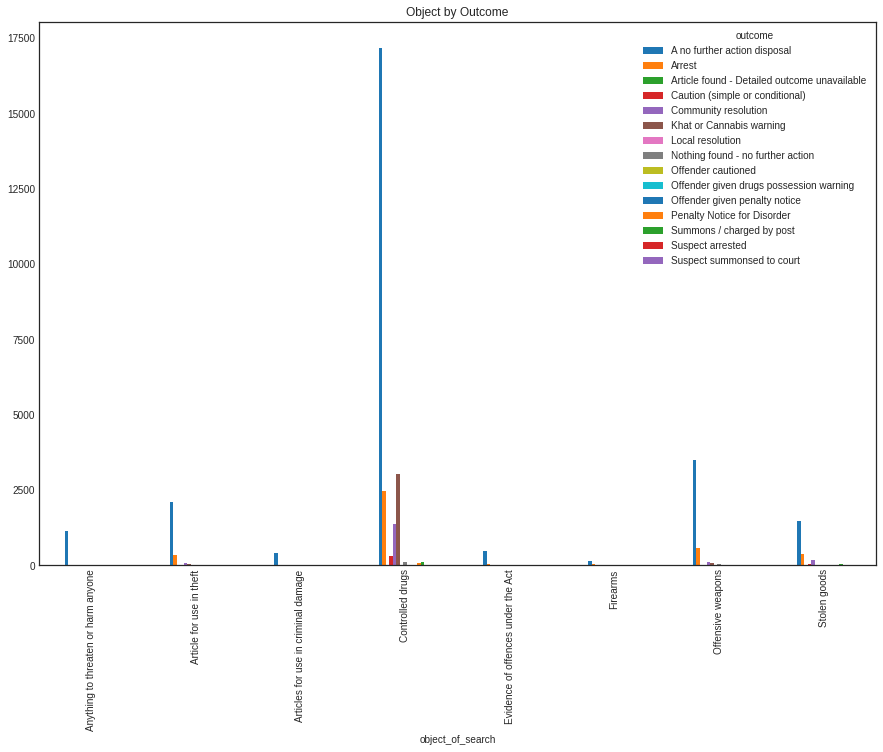

In [36]:
data.groupby('outcome')['object_of_search'].value_counts().unstack(0).plot.bar(title='Object by Outcome', figsize=(15,10));

In [37]:
data['gender'].value_counts()

Male      32198
Female     4192
Name: gender, dtype: int64

In [38]:
data['ethnicity'].value_counts()

White    29677
Black     3747
Asian     1600
Other     1366
Name: ethnicity, dtype: int64

In [39]:
data['age_range'].value_counts()

18-24       13670
10-17        9202
25-34        7464
over 34      6047
under 10        7
Name: age_range, dtype: int64

In [40]:
data['object_of_search'].value_counts()

Controlled drugs                       24730
Offensive weapons                       4348
Article for use in theft                2630
Stolen goods                            2207
Anything to threaten or harm anyone     1209
Evidence of offences under the Act       562
Articles for use in criminal damage      502
Firearms                                 202
Name: object_of_search, dtype: int64

In [41]:
Y_columns = ['gender','ethnicity','age_range']

cat_columns = []
num_columns = []

for col in data.columns.values:
    if col in Y_columns:
        continue
    elif data[col].dtypes == 'int64':
        num_columns += [col]
    else:
        cat_columns += [col]

print (Y_columns)

['gender', 'ethnicity', 'age_range']


In [42]:
def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    cnt = val.value_counts().sort_values(ascending=True)
    labels = cnt.index.values

    sizes = cnt.values
    colors = sns.color_palette("PuBu", len(labels))

    #------------COUNT-----------------------
    ax1.barh(cnt.index.values, cnt.values, color=colors)
    ax1.set_title('Count plot of '+y_var)

    #------------PERCENTAGE-------------------
    ax2.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%', shadow=True, startangle=130)
    ax2.axis('equal')
    ax2.set_title('Distribution of '+y_var)
    plt.show()

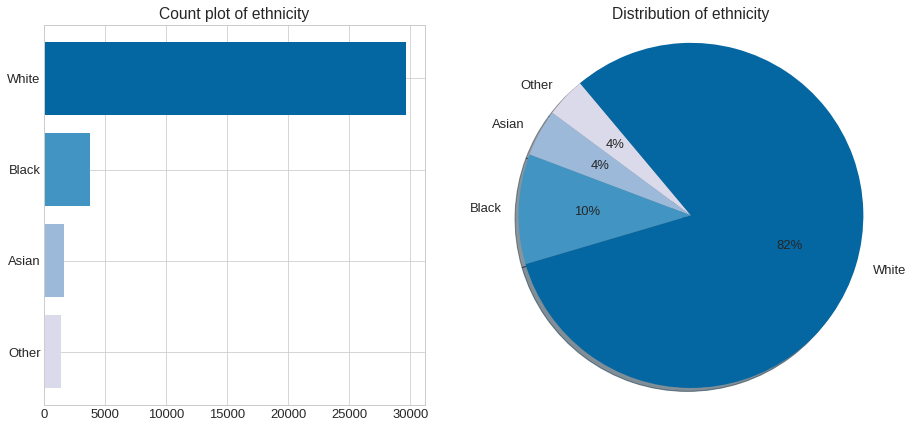

In [43]:
var = 'ethnicity'
target_distribution(y_var=var, data=data)

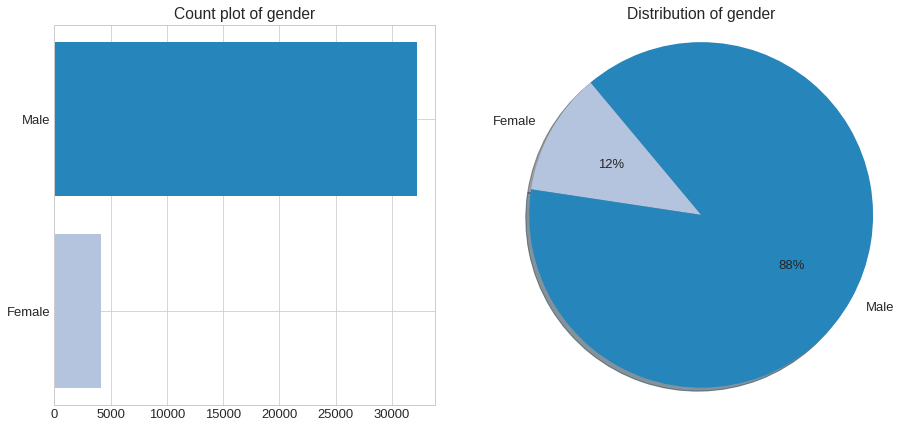

In [44]:
var = 'gender'
target_distribution(y_var=var, data=data)

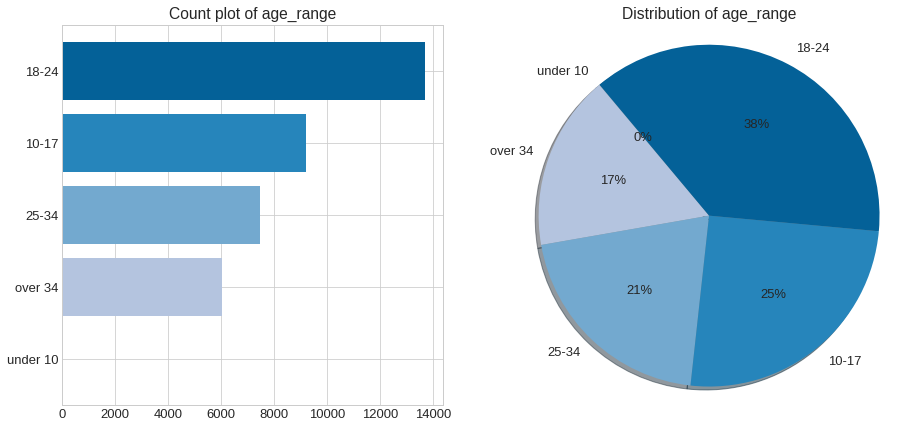

In [45]:
var = 'age_range'
target_distribution(y_var=var, data=data)

In [46]:
data['Frequency'] = 1
freq_target = data[['gender', 'ethnicity', 'age_range', 'Frequency']]
del data['Frequency']
freq_target = freq_target.groupby(by=['gender', 'ethnicity', 'age_range']).count() / len(data)
print(freq_target.sort_values(by='Frequency', ascending=False))

                            Frequency
gender ethnicity age_range           
Male   White     18-24       0.252707
                 10-17       0.189530
                 25-34       0.144023
                 over 34     0.126271
       Black     18-24       0.047595
Female White     18-24       0.035229
                 10-17       0.027590
Male   Black     25-34       0.022094
       Asian     18-24       0.021325
Female White     over 34     0.021105
                 25-34       0.018879
Male   Black     10-17       0.017944
       Other     18-24       0.013135
       Asian     25-34       0.011679
       Other     10-17       0.009893
       Black     over 34     0.009783
       Other     25-34       0.006210
       Asian     10-17       0.005029
                 over 34     0.004040
       Other     over 34     0.003435
Female Black     18-24       0.002638
       Other     18-24       0.002171
                 10-17       0.001319
       Black     10-17       0.001127
       Other

If we focus our model on the most common values, we find that there is a 25% probability that the police officer who stops you for a search is a white male between the ages of 18 and 24.



In [47]:
def plot_histo(data, col, Y_columns):
    df = data.copy()
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    
    for i in range(0,2):
        cnt = []; y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axs[i].hist(cnt, bins=bins, stacked=True)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Histogram of the "+col+" column by "+y_col)

    plt.show()

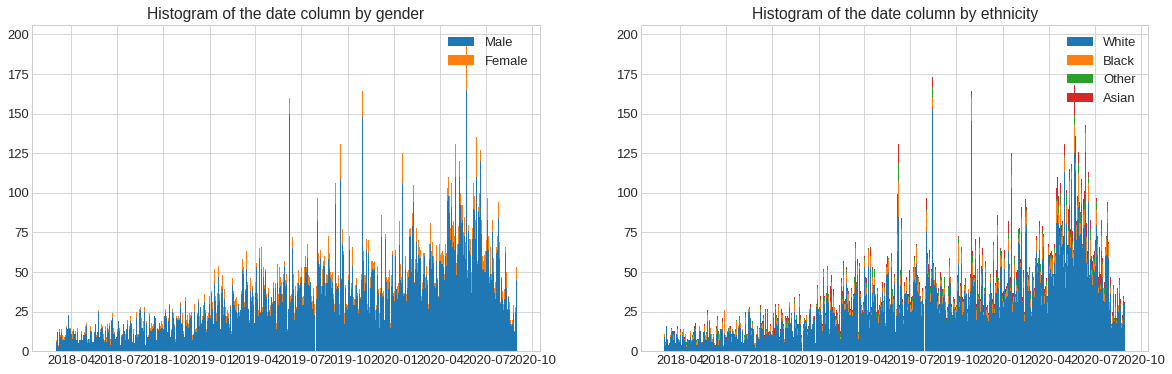

In [48]:
plot_histo(data, col='date',Y_columns=Y_columns)

Encoding

In [49]:
cat_columns

['type', 'date', 'object_of_search', 'outcome']

In [50]:
categorical_features = cat_columns + ['gender', 'ethnicity', 'age_range']
# categorical_features = categorical_features 
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

del cat_columns

In [51]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

In [52]:
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

del num_columns

In [53]:
data_encoded.head()

,type,date,gender,age_range,ethnicity,object_of_search,outcome
0,1.0,0.0,1.0,1.0,3.0,3.0,9.0
1,0.0,0.0,1.0,1.0,3.0,3.0,9.0
2,1.0,0.0,1.0,2.0,3.0,3.0,9.0
3,0.0,0.0,1.0,1.0,3.0,3.0,7.0
4,0.0,0.0,1.0,1.0,3.0,3.0,7.0


Since this dataset is difficult to comprehend for a person, let's write a function to restore the original values.



In [54]:
def decode_dataset(data, encoders, numerical_features, categorical_features):
    df = data.copy()
    for feat in df.columns.values:
        if feat in numerical_features:
            df[feat] = encoders[feat].inverse_transform(np.array(df[feat]).reshape(-1, 1))
    for feat in categorical_features:
        df[feat] = encoders[feat].inverse_transform(df[feat].astype(int))
    return df

In [55]:
decode_dataset(data_encoded, encoders=encoders, numerical_features=numerical_features, categorical_features=categorical_features).head()

,type,date,gender,age_range,ethnicity,object_of_search,outcome
0,Person search,2018-03-01,Male,18-24,White,Controlled drugs,Offender given drugs possession warning
1,Person and Vehicle search,2018-03-01,Male,18-24,White,Controlled drugs,Offender given drugs possession warning
2,Person search,2018-03-01,Male,25-34,White,Controlled drugs,Offender given drugs possession warning
3,Person and Vehicle search,2018-03-01,Male,18-24,White,Controlled drugs,Nothing found - no further action
4,Person and Vehicle search,2018-03-01,Male,18-24,White,Controlled drugs,Nothing found - no further action



***Real Target for the Project***

Create dataset using aif360

In [56]:
data_perp_sex = data_encoded.drop(['object_of_search'], axis=1)

In [57]:
privileged_sex = np.where(categorical_names['gender'] == 'Male')[0]
privileged_race = np.where(categorical_names['ethnicity'] == 'White')[0]

In [58]:
data_orig_outcome = StandardDataset(data_perp_sex, 
                               label_name='outcome', 
                               favorable_classes=[1], 
                               protected_attribute_names=['gender', 'ethnicity'], 
                               privileged_classes=[privileged_sex, privileged_race])

In [59]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dataset shape"))
    print(dataset.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset.feature_names)

In [60]:
meta_data(data_orig_outcome)

#### Dataset shape

(36390, 5)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['gender', 'ethnicity']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([3.])] [array([0.]), array([0., 1., 2.])]


#### Dataset feature names

['type', 'date', 'gender', 'age_range', 'ethnicity']


**First models**

I'd like to emphasise that the main aim of this Kernel is to figure out how to avoid bias in our model, not to get a performant model. So I'll just make a simple Random Forest model.

Split into train and test set

In [61]:
np.random.seed(42)

data_orig_outcome_train, data_orig_outcome_test = data_orig_outcome.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("outcome :",data_orig_outcome_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("outcome :",data_orig_outcome_test.features.shape)

#### Train Dataset shape

outcome : (25473, 5)


#### Test Dataset shape

outcome : (10917, 5)


In [62]:
# Train and save the models
rf_orig_outcome = RandomForestClassifier().fit(data_orig_outcome_train.features, 
                     data_orig_outcome_train.labels.ravel(), 
                     sample_weight=data_orig_outcome_train.instance_weights)

In [63]:
#predict on test set

X_test_outcome = data_orig_outcome_test.features
y_test_outcome = data_orig_outcome_test.labels.ravel()

In [64]:
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")  

#### Accuracy of the model :

0.8594852065585784


#### F1 score of the model :

0.17349137931034483


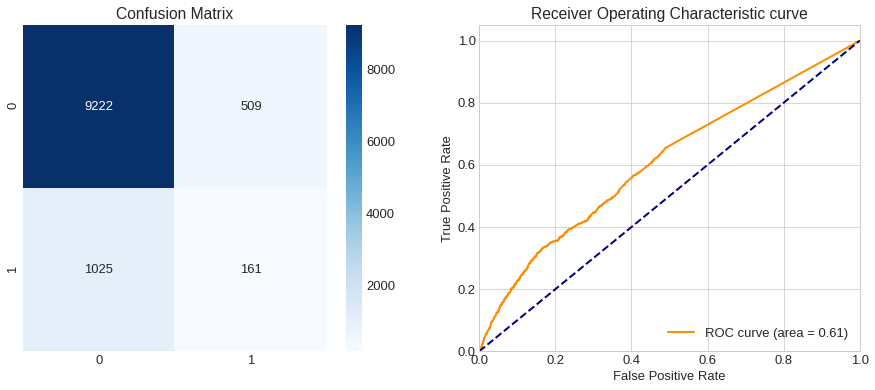

In [65]:
plot_model_performance(rf_orig_outcome, data_orig_outcome_test.features, y_test_outcome)

**Bias and Fairness**



In [66]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [67]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
      

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [68]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Bias metrics for the Outcome model

#### Original dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.012333


#### Original dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.066419


### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the gender attribute :

With default thresholds, bias against unprivileged group detected in **3** out of 5 metrics

#### For the ethnicity attribute :

With default thresholds, bias against unprivileged group detected in **3** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
gender,0.012333,0.320286,0.162217,1.223173,0.061946
ethnicity,0.066419,0.462931,0.231908,2.479366,0.061946


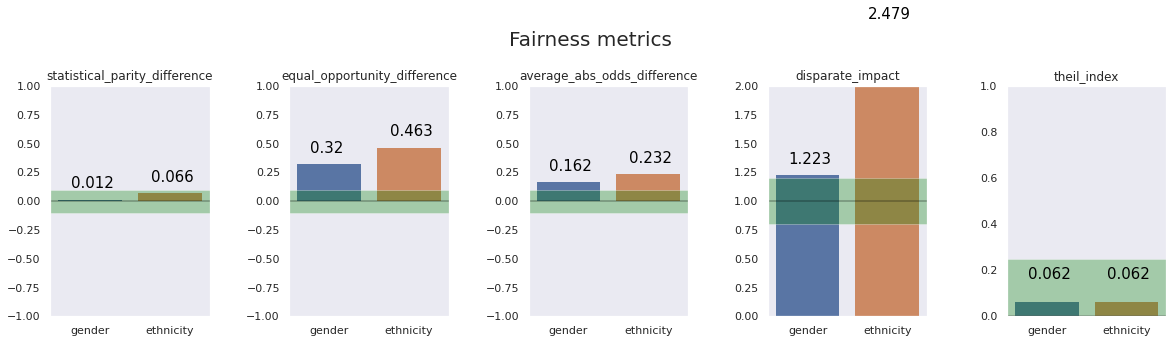

In [69]:
display(Markdown('### Bias metrics for the Outcome model'))
fair = get_fair_metrics_and_plot(data_orig_outcome_train, rf_orig_outcome) 

#data_orig_outcome_test

In [70]:
data_orig_test = data_orig_outcome_test
data_orig_train = data_orig_outcome_train
rf = rf_orig_outcome

probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

As we can see, this first model is biased. The next step is to answer the question : How to fix it ?

How to fix it ?

AIF360 use 3 types of algorithms :

**Pre-processing algorithms** : they are used before training the model

**In-processing algorithms** : they are fair classifiers so it's during the training

**Post-processing algorithms** : they are used after training the model Fairness pipeline

This is the fairness pipeline. Loading data into a dataset object, transforming it into a fairer dataset using a fair pre-processing algorithm, learning a classifier from this transformed dataset, and obtaining predictions from this classifier are some examples of how this generic pipeline can be used. On the original, transformed, and predicted datasets, as well as between the transformed and predicted datasets, metrics can be calculated. There are several other instantiations that can be produced.

# 1. Pre-processing algorithms

There are four pre-processing algorithms, but three of them have a flaw: they only function if the dataset contains one protected attribute, but we have two: Race and sex.

**Reweighing**



In [71]:
privileged_groups = [{'ethnicity': 3}]
unprivileged_groups = [{'ethnicity': 1}] 

t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'Reweighing')
print('time elapsed : %.2fs'%(time()-t0))

#### Original dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.010140


#### Original dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.038448
time elapsed : 3.28s


In [72]:
new_transf_train = BinaryLabelDatasetMetric(data_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % new_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


# 2. In-processing algorithms

***Adversarial Debiasing***

Adversarial debiasing is an in-processing technique that learns a classifier to increase prediction accuracy while reducing an adversary's ability to deduce the protected attribute from the predictions. Since the predictions cannot contain any group discrimination information that the adversary can manipulate, this method yields a fair classifier.

In [73]:
min_max_scaler = MaxAbsScaler()
data_orig_train.features = min_max_scaler.fit_transform(data_orig_train.features)
data_orig_test.features = min_max_scaler.transform(data_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(data_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(data_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.042664
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.040051


In [74]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [75]:
plain_model.fit(data_orig_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.778669
epoch 1; iter: 0; batch classifier loss: 0.300581
epoch 2; iter: 0; batch classifier loss: 0.328099
epoch 3; iter: 0; batch classifier loss: 0.314936
epoch 4; iter: 0; batch classifier loss: 0.321120
epoch 5; iter: 0; batch classifier loss: 0.325252
epoch 6; iter: 0; batch classifier loss: 0.252816
epoch 7; iter: 0; batch classifier loss: 0.369295
epoch 8; iter: 0; batch classifier loss: 0.336220
epoch 9; iter: 0; batch classifier loss: 0.313218
epoch 10; iter: 0; batch classifier loss: 0.272155
epoch 11; iter: 0; batch classifier loss: 0.326838
epoch 12; iter: 0; batch classifier loss: 0.304000
epoch 13; iter: 0; batch classifier loss: 0.324430
epoch 14; iter: 0; batch classifier loss: 0.333693
epoch 15; iter: 0; batch classifier loss: 0.408308
epoch 16; iter: 0; batch classifier loss: 0.325224
epoch 17; iter: 0; batch cla

In [76]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(data_orig_train)
dataset_nodebiasing_test = plain_model.predict(data_orig_test)

In [77]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(data_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.891362
Test set: Balanced classification accuracy = 0.500000
Test set: Disparate impact = nan
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil_index = 0.115005


Apply in-processing algorithm based on adversarial learning

In [78]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

debiased_model.fit(data_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.682715; batch adversarial loss: 0.739928
epoch 1; iter: 0; batch classifier loss: 0.247077; batch adversarial loss: 0.251217
epoch 2; iter: 0; batch classifier loss: 0.274790; batch adversarial loss: -0.146164
epoch 3; iter: 0; batch classifier loss: 0.305819; batch adversarial loss: -0.527809
epoch 4; iter: 0; batch classifier loss: 0.294153; batch adversarial loss: -1.021226
epoch 5; iter: 0; batch classifier loss: 0.464132; batch adversarial loss: -1.351706
epoch 6; iter: 0; batch classifier loss: 0.373788; batch adversarial loss: -1.512182
epoch 7; iter: 0; batch classifier loss: 0.628004; batch adversarial loss: -1.933014
epoch 8; iter: 0; batch classifier loss: 0.539630; batch adversarial loss: -2.166244
epoch 9; iter: 0; batch classifier loss: 0.600009; batch adversarial loss: -2.783957
epoch 10; iter: 0; batch classifier loss: 0.397209; batch adversarial loss: -2.911793
epoch 11; iter: 0; batch classifier loss: 0.296640; batch adversar

In [79]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(data_orig_train)
dataset_debiasing_test = debiased_model.predict(data_orig_test)

In [80]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(data_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.000000


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.891362
Test set: Balanced classification accuracy = 0.500000
Test set: Disparate impact = nan
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil_index = 0.115005


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.856646
Test set: Balanced classification accuracy = 0.502738
Test set: Disparate impact = nan
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000000
Test set: Theil_index = 0.124487


# 3. Post-processing algorithms

It exists 3 post-processing algorithms with aif360.


***Reject Option Classification***

In a confidence band around the decision boundary with the highest uncertainty, postprocessing method like Reject option classification gives favourable outcomes to unpriviliged groups and unfavourable outcomes to priviliged groups.

In [81]:
# Get the dataset and split into train and test
dataset_post_train, dataset_post_vt = data_orig_outcome.split([0.7], shuffle=True)
dataset_post_valid, dataset_post_test = dataset_post_vt.split([0.5], shuffle=True)

In [82]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_post_train.features)
y_train = dataset_post_train.labels.ravel()

rf_transf.fit(X_train, y_train)
y_train_pred = rf_transf.predict(X_train)

# positive class index
pos_ind = np.where(rf_transf.classes_ == dataset_post_train.favorable_label)[0][0]

dataset_post_train_pred = dataset_post_train.copy(deepcopy=True)
dataset_post_train_pred.labels = y_train_pred

In [83]:
dataset_post_valid_pred = dataset_post_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_post_valid_pred.features)
y_valid = dataset_post_valid_pred.labels
dataset_post_valid_pred.scores = rf_transf.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_post_test_pred = dataset_post_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_post_test_pred.features)
y_test = dataset_post_test_pred.labels
dataset_post_test_pred.scores = rf_transf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

Find the optimal parameters from the validation set

In [84]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_post_valid_pred.scores > class_thresh
    dataset_post_valid_pred.labels[fav_inds] = dataset_post_valid_pred.favorable_label
    dataset_post_valid_pred.labels[~fav_inds] = dataset_post_valid_pred.unfavorable_label
    
    classified_metric_post_valid = ClassificationMetric(dataset_post_valid,
                                             dataset_post_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_post_valid.true_positive_rate()\
                       +classified_metric_post_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.5869
Optimal classification threshold (no fairness constraints) = 0.0199


Estimate optimal parameters for the ROC method

In [85]:
# Metric used (should be one of allowed_metrics)
metric_name = "Statistical parity difference"

# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05

# Verify metric name
allowed_metrics = ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]
if metric_name not in allowed_metrics:
    raise ValueError("Metric name should be one of allowed metrics")

ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_post_valid, dataset_post_valid_pred)

In [86]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.0694
Optimal ROC margin = 0.0085


Predictions from Validation Set

In [87]:
# Metrics for the test set
fav_inds = dataset_post_valid_pred.scores > best_class_thresh
dataset_post_valid_pred.labels[fav_inds] = dataset_post_valid_pred.favorable_label
dataset_post_valid_pred.labels[~fav_inds] = dataset_post_valid_pred.unfavorable_label

display(Markdown("#### Validation set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_valid_bef = compute_metrics(dataset_post_valid, dataset_post_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.5869
Statistical parity difference = 0.1282
Disparate impact = 1.3044
Average odds difference = 0.1420
Equal opportunity difference = 0.1723
Theil index = 0.1014


In [88]:
# Transform the validation set
dataset_transf_valid_pred = ROC.predict(dataset_post_valid_pred)

display(Markdown("#### Validation set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_valid_aft = compute_metrics(dataset_post_valid, dataset_transf_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.5827
Statistical parity difference = 0.0453
Disparate impact = 1.1346
Average odds difference = 0.0206
Equal opportunity difference = -0.0021
Theil index = 0.1110


In [89]:
# Testing: Check if the metric optimized has not become worse
assert np.abs(metric_valid_aft[metric_name]) <= np.abs(metric_valid_bef[metric_name])

In [90]:
# Metrics for the test set
fav_inds = dataset_post_test_pred.scores > best_class_thresh
dataset_post_test_pred.labels[fav_inds] = dataset_post_test_pred.favorable_label
dataset_post_test_pred.labels[~fav_inds] = dataset_post_test_pred.unfavorable_label

display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_test_bef = compute_metrics(dataset_post_test, dataset_post_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.5817
Statistical parity difference = 0.0940
Disparate impact = 1.2287
Average odds difference = 0.1143
Equal opportunity difference = 0.1493
Theil index = 0.1048


In [91]:
# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_post_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_test_aft = compute_metrics(dataset_post_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.5812
Statistical parity difference = 0.0181
Disparate impact = 1.0559
Average odds difference = 0.0374
Equal opportunity difference = 0.0709
Theil index = 0.1135
